In [147]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import scipy.stats as stats
import scipy.integrate as integrate
import pymc3 as pm
from random import choices
%matplotlib notebook

# Observations

## Forcing
Using Bellouin aerosol forcing as calculated by Piers and Mark for (Sherwood et al, 2020)

In [3]:
def bellouin_ringberg_stats_fix_200311_ERFaer(nsamples):
#From WCRP code downloaded 3/10
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import math

    # Distribution type
    # u - uniform, but arguments are 16th and 84th percentile
    #       assumes uniform outside these values (no very large values)
    # v - uniform, next two arguments are upper and lower bounds
    # c - constant value
    # n - normal distribution with bounds as 2 sigma width around an average mean

    d = {}
    d['rsdt'] =          ['c', -340]

    # Aerosol variables
    d['dtau'] =          ['u', 0.02,   0.04]
    d['tau'] =           ['u', 0.13,   0.17]

    # RFari terms
    d['S_tau'] =         ['u', -20,   -27]
    d['RFari_cloudy'] =  ['u', -0.1, 0.1 ]

    # RAari
    d['dR_dRatm'] =      ['u', -0.1, -0.3]
    d['dRatm_dtau'] =    ['u', 17,     35]

    # Cloud fractions
    d['c_tau'] =         ['u', 0.59,  0.71]
    d['c_N'] =           ['u', 0.19,  0.29]
    d['c_L'] =           ['u', 0.21, 0.29 ]
    d['c_C'] =           ['u', 0.59, 1.07 ]         

    # Nd sensitivity to aerosol, and adjustment terms
    d['beta_N_tau'] =   ['u', 0.3,    0.8]
    d['beta_L_N'] =     ['u', -0.36,  -0.011] 
    d['beta_C_N'] =       ['u', 0,      0.1]

    # Cloud albedo terms
    d['S_N'] =           ['u', -26,    -27]
    d['S_L'] =           ['u', -54,    -56]
    d['S_C'] =           ['u', -91,   -153]


    ############################################
    # Create the distributions and store in ds #
    ############################################

    ds = {}
    for name in d.keys():
      if d[name][0] == 'c':
          ds[name] = d[name][1]
      elif d[name][0] == 'u':
          diff = 16*(d[name][2]-d[name][1])/(84-16)
          ds[name] = np.random.uniform(d[name][1]-diff, d[name][2]+diff, nsamples)
      elif d[name][0] == 'v':
          ds[name] = np.random.uniform(d[name][1], d[name][2], nsamples)
      elif d[name][0] == 'n':
          cent = (d[name][2]+d[name][1])/2
          spread = (d[name][2]-d[name][1])/2
          ds[name] = np.random.uniform(cent, spread, nsamples)

    ############################
    # The Ringberg Equation!!! #
    ############################
    rfari = ds['dtau']*ds['S_tau']*(1-ds['c_tau'])+ds['RFari_cloudy']
    rfari_adj = ds['dtau']*ds['dR_dRatm']*ds['dRatm_dtau']

    ds['dlntau'] = ds['dtau']/ds['tau']
    deltan = ds['dlntau']*ds['beta_N_tau']

    rfaci = ds['dlntau']*ds['beta_N_tau']*ds['S_N']*ds['c_N']
    erfaci_L = ds['dlntau']*ds['beta_N_tau']*ds['beta_L_N']*ds['S_L']*ds['c_L']
    erfaci_C = ds['dlntau']*ds['beta_N_tau']*ds['beta_C_N']*ds['S_C']*ds['c_C']

    ERFaer=rfari+rfari_adj+rfaci+erfaci_L+erfaci_C
    return ERFaer

## Total historical forcing
Code written by Mark Webb, modified (slightly) by K Marvel 3/7/22

In [4]:
def read_hist_forc(hist_forcing_version='Bellouin_2020_eqn_8',\
                   alternative_pi_period=False,
                  period_1850_2005_2015=False,\
                  period_1750_2018=False):
    inpath = "WCRP_ECS_assessment_code_200714/"
    #start by making the forcing according to Piers' code and commentary

    #note the only edit I made to his files is to make the col names automatically readable for the 2nd one (ie removing spaces)

    # Piers Forster's code retained in comments marked PF 
    # James Annan's code retained in comments marked JDA



    # Read in data

    from io import StringIO   # StringIO behaves like a file object
    #from google.colab import drive
    #drive.mount('/content/gdrive')

    # **** Read in historical forcing upper, mid and lower ranges ****

    if hist_forcing_version == 'Bellouin_2020_eqn_8':
        hist_forcing_ranges='WCRP_forcing_ranges_200311.csv'
        hist_monthly_forcings='Forster_forcings_2018_WCRP_Bellouinaerosol2.csv'

    if hist_forcing_version == 'Bellouin_2020_constrained':
        hist_forcing_ranges='WCRP_forcing_ranges_Bellouinaerosol_constrained_200321.csv'
        hist_monthly_forcings='Forster_forcings_2018_WCRP_Bellouinaerosol2.csv'

    if hist_forcing_version == 'AR5_extended':
        hist_forcing_ranges='IPCCAR5_forcing_ranges_200320.csv'
        hist_monthly_forcings='Forster_forcings_2018_WCRP_AR5aerosol_200320.csv'

    best_upper_lower = pd.read_csv(inpath+hist_forcing_ranges,nrows=3)

    best=best_upper_lower.iloc[0]
    lower=best_upper_lower.iloc[1]
    upper=best_upper_lower.iloc[2]

    # PF ; assumes 90% are 1.65 sigma
    # PF sdlower=(best-lower)/1.65
    # PF sdupper=(upper-best)/1.65

    # MJW calulate standard deviations which would give lower and upper values as 5-95% ranges
    # assumes 90% are 1.64 sigma
    sdlower=(best-lower)/1.64
    sdupper=(upper-best)/1.64

    

    # **** Read in AR5 annual mean forcing data ****

    df=pd.read_csv(inpath+hist_monthly_forcings,delimiter=',',skiprows=19)

    #print (forc_table["Year/month"]
    df = df.set_index(['Year/month']) 

    df_baseline=df.loc[1861:1880]
    #df_recent=df.loc[2002:2017]
    df_recent=df.loc[2006:2018] # updated 16/3/20

    if alternative_pi_period:
        df_baseline=df.loc[1850:1900]

    if period_1850_2005_2015:
        df_baseline=df.loc[[1850,1850]]
        df_recent=df.loc[2005:2015]

    if period_1750_2018:
        df_baseline=df.loc[[1750,1750]]
        df_recent=df.loc[[2018,2018]]

   # print (df_baseline)
   # print (df_recent)

    # JDA: CO2 forcing is based on F2x so I will back-calculate the doubling fraction from this
    #
    # JDA: now generate a sample of all the other forcings

    uncs_neg = ( best - lower ) / (1.64 * best )
    uncs_pos = ( upper - best ) / (1.64 * best )

    return (df_recent,df_baseline,uncs_neg,uncs_pos)

In [5]:
def get_total_forcing(nsamp):
    #Aerosol forcing is different- median is -1.1, not -1.179
    df_recent,df_baseline,uncs_neg,uncs_pos=read_hist_forc()

   
    labels = ['Other WMGHG','O3 (T)','O3(S)','ERF LUC','Vapour','BC snow','contrails','Solar','Volcanic',"total aerosol ERF"] 
    f_other = np.zeros(nsamp)
    devs = np.random.normal(loc=0.0, scale=1.0, size=nsamp)
    for label in labels:
        baseline=df_baseline[label].to_numpy()
        baseline=np.mean(baseline)

        recent=df_recent[label].to_numpy()
        recent=np.mean(recent)

        if label != "total aerosol ERF":

            devscaled = (devs >= 0) * devs * uncs_pos[label] 
            devscaled = devscaled + (devs < 0) * devs * uncs_neg[label]
            f_component = (recent - baseline) * (1+devscaled)
            f_other=f_other+f_component
        else:
            #aerosols
            ERFaer = bellouin_ringberg_stats_fix_200311_ERFaer(nsamp)
            #devscaled=ERFaer/np.median(ERFaer)-1.0
            # rescale by the factor that reproduces Bellouin et al 2020 PDF between 1850 and 2005-2015
            peak_ERFaer=-0.87
            devscaled=ERFaer/peak_ERFaer-1.0
            #print(recent-baseline)
            total_aerosol_forcing=(recent - baseline) * (1+devscaled)
            #print("Aerosol 5-95 range",np.percentile(total_aerosol_forcing,5),np.percentile(total_aerosol_forcing,95))
            #print("aserosol median",np.median(total_aerosol_forcing))


    #CO2
    label='CO2'
    baseline=df_baseline[label].to_numpy()
    baseline=np.mean(baseline)

    recent=df_recent[label].to_numpy()
    recent=np.mean(recent)

    CO2_hist_mean = (recent - baseline)

    F2x=4.
    F2x_error=np.random.normal(F2x,0.49/1.64,size=nsamp)
    CO2_hist=CO2_hist_mean*F2x/np.mean(F2x)

    tot_f=f_other+total_aerosol_forcing+CO2_hist
    return tot_f


$\Delta F$ = Baseline ERF 1861-1880 to 2006-2018 using Bellouin et al (2020) unconstrained aerosol PDF
## Other observations


Temperature and imbalance estimates taken from Table 5 of (Sherwood et al 2020); 5-95% confidence levels converted into $\sigma$ using normal distribution

$\Delta T \sim \mathcal{N}(1.03,0.085)$

$\Delta N \sim \mathcal{N}(0.6,0.18)$

In [6]:
nsamp=1000
scale90=stats.norm.interval(.9)[1]

dF_obs=get_total_forcing(nsamp)
dT_obs=np.random.normal(1.03,(.17-.03)/scale90,nsamp)
dN_obs=np.random.normal(.6,0.3/scale90,nsamp)

x=dN_obs-dT_obs

F2x=4.
F2x_error=np.random.normal(F2x,0.49/1.64,size=nsamp)
    

Calculate a kernel density estimate from these samples (do this numerically since we don't have a functional form for $\Delta F$)

In [7]:
test_values=np.zeros((3,nsamp))
test_values[0]=dT_obs
test_values[1]=dF_obs
test_values[2]=dN_obs


test_kde=stats.gaussian_kde(test_values)

# Visualizing the joint probability
Assuming the measurement errors of forcing, temperature, and ocean heat uptake are uncorrelated, the KDE represents the joint probability density

<IPython.core.display.Javascript object>


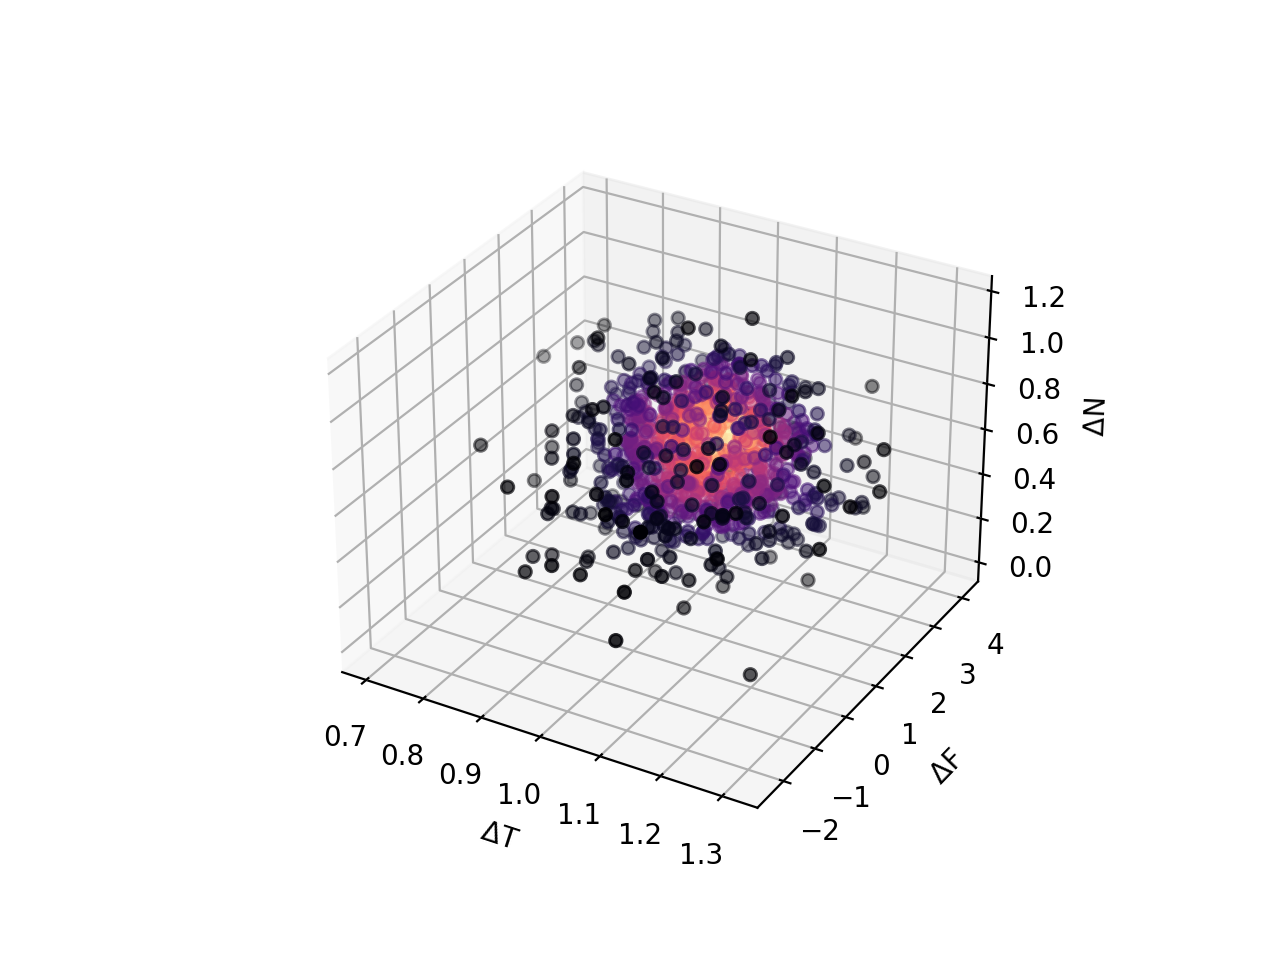

In [8]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
plt.set_cmap(cm.magma)
ax.scatter(test_values[0], test_values[1], test_values[2], c=test_kde(test_values))
tmp=ax.set_xlabel(r'$\Delta$T')
tmp=ax.set_ylabel(r'$\Delta$F')
tmp=ax.set_zlabel(r'$\Delta$N')
plt.show()

# Simple model
The simplest energy balance model is 

$\Delta N = \lambda \Delta T + \Delta F$

This is deterministic: if we knew the "true" values of the imbalance, temperature change, and forcing, we'd know the feedback parameter exactly.  That is: there is no randomness in $\lambda$ or uncertainty in this model: the uncertainty in $\lambda$ is completely due to the uncertainty in the observations. 

(Aside: if we consider shorter-term observations, we have to consider internal variability.  In that case, the model is $$\Delta N = \lambda \Delta T + \Delta F+V$$ and we have to consider a further hierarchical step 
$$\lambda_{obs} \sim \mathcal{N}(\lambda_{true},\sigma_V^2)$$ where we assume the observed values of $\lambda$ are normally distributed about the "true" (latent) feedback parameter and $\sigma_V^2$ represents the scatter due to internal variability of the climate system.  But let's not get ahead of ourselves.)

This model defines a plane in $(\Delta T, \Delta N, \Delta F)$ space.

In [9]:
def plot_plane_lam(lam,ax=plt.gca()):
    Ts = np.linspace(.8,1.3,int(nsamp/100))
    Fs = np.linspace(-2,4.0,int(nsamp/100))
    xx,yy=np.meshgrid(Ts,Fs)
    #zz = -1/lam*(xx-yy)
    zz = lam*xx+yy
    ax.plot_surface(xx,yy,zz,alpha=.3,label="lam = "+str(lam))

Intuitively, the likelihood of the observed evidence given a value of $\lambda$ depends on the intersection of the plane defined by $\lambda$ and the joint PDF of the observations.  A plane that cuts through a large section of the PDF corresponds to a high likelihood of the evidence given that particular $\lambda$, while a plane that just grazes the side corresponds to a low likelihood.  This is a 3D generalization of the method used in Sherwood et al for the historical section.

<IPython.core.display.Javascript object>


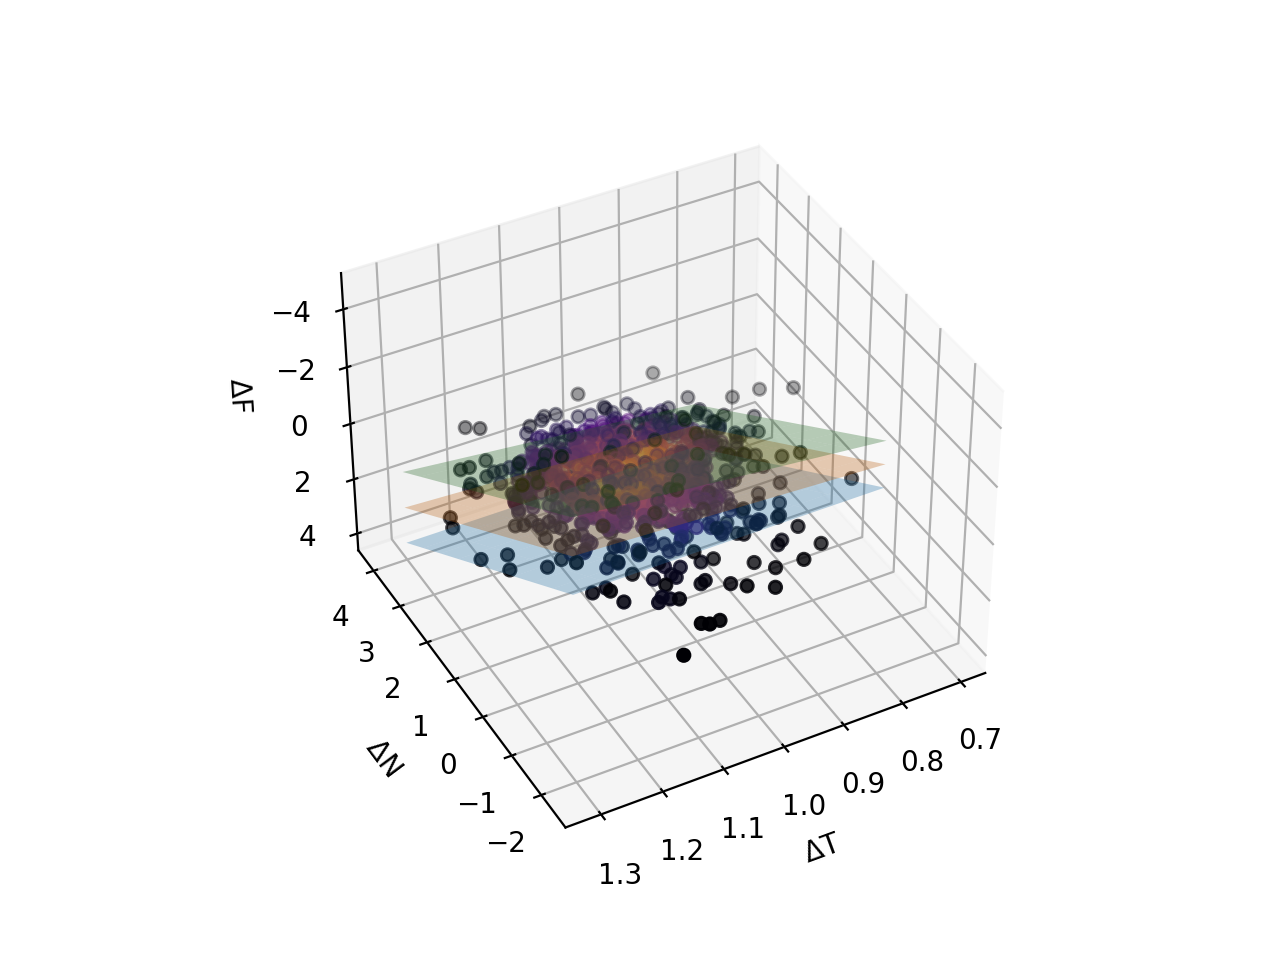

In [19]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
plt.set_cmap(cm.magma)
ax.scatter(test_values[0], test_values[1], test_values[2], c=test_kde(test_values))
tmp=ax.set_xlabel(r'$\Delta$T')
tmp=ax.set_ylabel(r'$\Delta$N')
tmp=ax.set_zlabel(r'$\Delta$F')

plot_plane_lam(0,ax=ax)
plot_plane_lam(-1,ax=ax)
plot_plane_lam(-2,ax=ax)
plt.show()

Define the likelihood as the surface integral of the joint PDF of observations over the plane defined by $\lambda$:

$$\int \int PDF(\Delta T, \Delta F, \Delta N) dS = \int \int PDF( \vec{r}(u,v) )|| r_u \times r_v|| dA$$
where 
$$\vec{r} =u \hat{i} + v \hat{j} + (\lambda u+ v)\hat{k}$$
If the observations $\Delta T, \Delta F, \Delta N$ are all independent and normally distributed, we can write this integral in terms of Gaussians and get a nice analytic functional form.  This is moot because $\Delta F$ is not normally distributed.  So let's do it numerically:

In [134]:
#Functional form of the likelihood P(evidence | λ)
#This takes longer than I'd like, but maybe we can fit a spline to a bunch of samples to make it go faster
def likelihood_density_lambda(λ,tmin=-10,tmax=10,qmin=-10,qmax=10):
    ru=np.array([1,0,λ])
    rv=np.array([0,1,1])
    jacobian=np.linalg.norm(np.cross(ru,rv))
    func=lambda u,v: test_kde((u,v,λ*u+v))*jacobian
    return integrate.dblquad(func,tmin,tmax,lambda u: qmin, lambda u: qmax)[0]

Let's get a functional form for the likelihood $P(\Delta T, \Delta F, \Delta N | \lambda)$:

In [12]:
lams=np.linspace(-5,1,50)
tst_lams=[]
for lam in lams:
    tst_lams+=[likelihood_density_lambda(lam,tmin=-np.inf,tmax=np.inf,qmin=-np.inf,qmax=np.inf)]

/Users/kmarvel/Applications/anaconda3/envs/machine_learning/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Compare to the Gaussian likelihood obtained from the process evidence

<IPython.core.display.Javascript object>


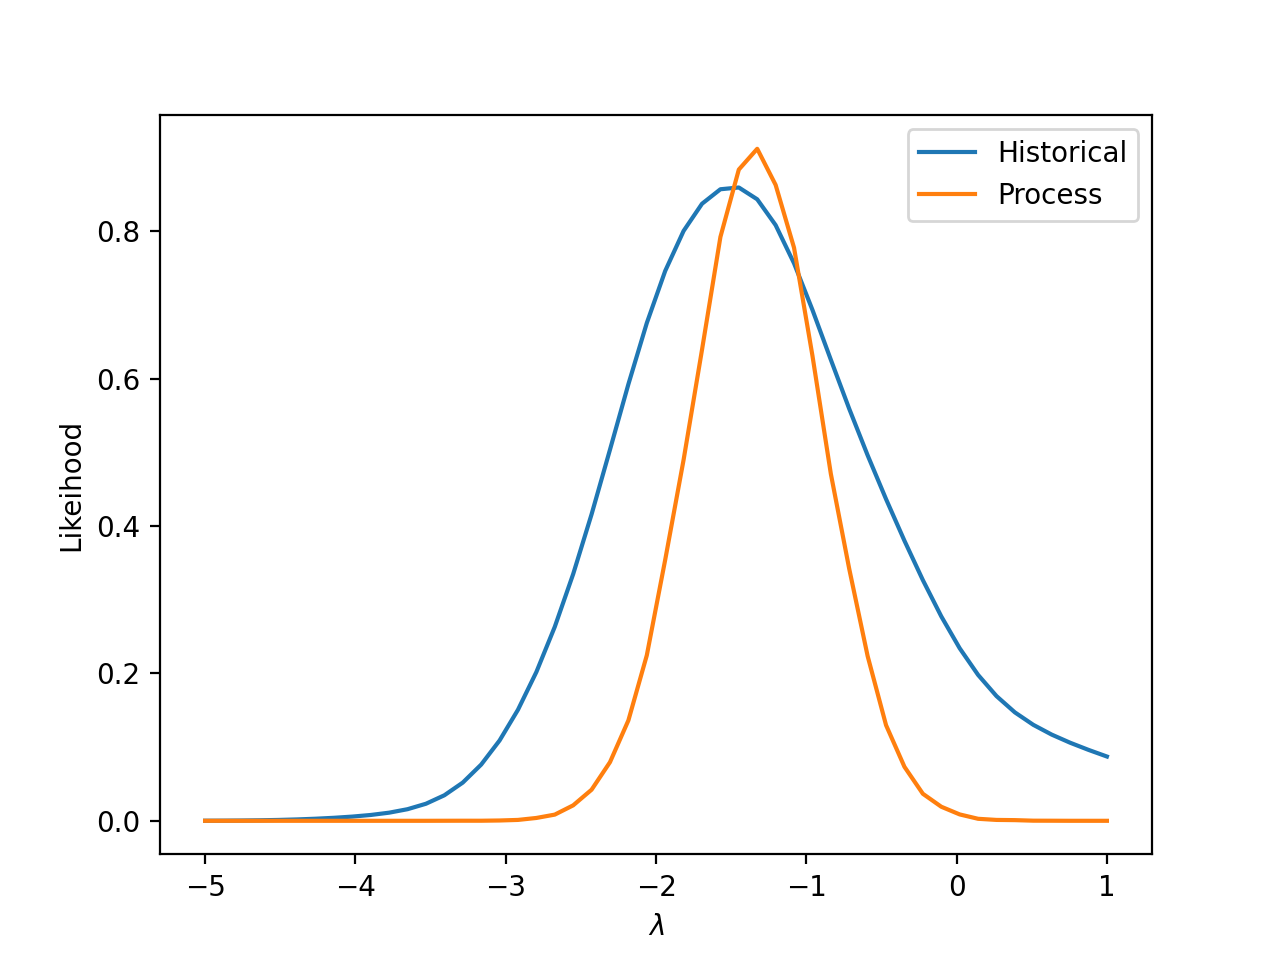

In [138]:
process_kde=stats.gaussian_kde(np.random.normal(-1.33,.44,100000))
fig=plt.figure()
ax=fig.add_subplot(111)
plt.plot(lams,tst_lams,label="Historical")
plt.plot(lams,process_kde(lams),label="Process")
plt.show()
plt.xlabel(r"$\lambda$")
plt.ylabel("Likeihood")
plt.legend()

# Paleo
Now, let's do the same thing for the paleo evidence, starting with the Last Glacial Maximum.  Unclear whether I should use $\Delta T$ from Sherwood et al or the updated value from Tierney et al...

In [44]:
#Tierney
#dT_LGM=np.random.normal(-6.1,(6.5-5.7)/scale90,nsamp)

#Annan
dT_LGM = np.random.normal(loc=-5.0,scale=1.0,size=nsamp)

dF_LGM = np.random.normal(loc=-8.8,scale=2.0,size=nsamp)
#dF_LGM_ice=np.random.normal(-3.2,0.7/scale90,nsamp)
#dF_LGM_GHG=-0.57*F2x_error+ 
#dF_LGM_dust = np.random.normal(-1.0,1./scale90,nsamp)
#dF_LGM_veg = np.random.normal(-1.1,0.6/scale90,nsamp)

Assuming our observations of the LGM reflect a climate at equilibrium, $\Delta N =0$ and we are just dealing with a 2D joint PDF

<IPython.core.display.Javascript object>


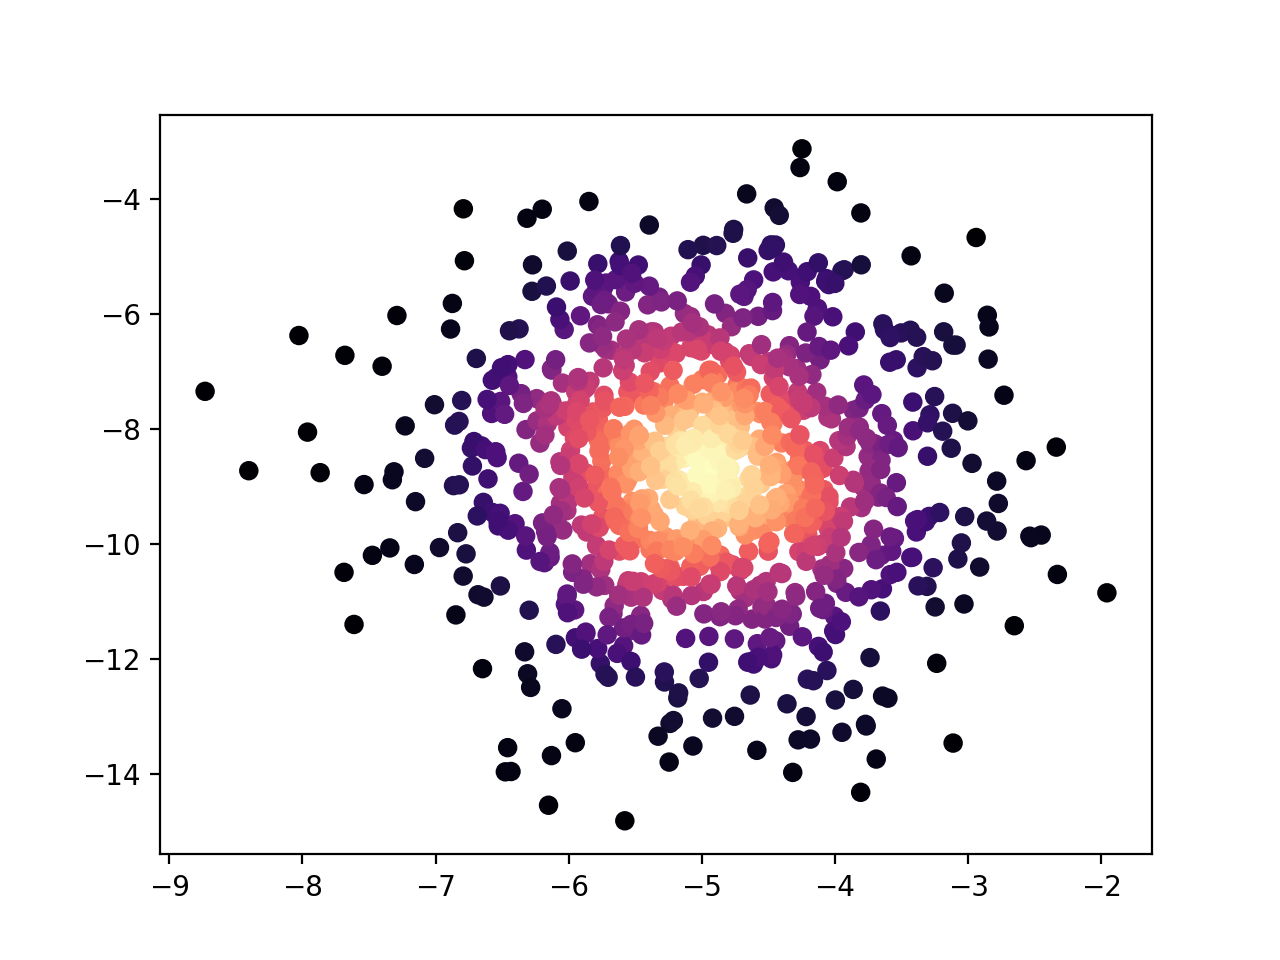

In [45]:
LGM_values=np.zeros((2,nsamp))
LGM_values[0]=dT_LGM
LGM_values[1]=dF_LGM


fig=plt.figure()
ax=fig.add_subplot(111)
LGM_kde=stats.gaussian_kde(LGM_values)

ax.scatter(LGM_values[0], LGM_values[1],  c=LGM_kde(LGM_values))

## Model for the last glacial maximum
Let's assume (for now) the pattern effect during the last glacial maxiumum is zero but that there might be state dependence.  In that case, our model is 
$$0 = \lambda \Delta T - 2\alpha \Delta T^2 + \Delta F$$
and the likelihood is given by the line integral of the joint PDF over this curve

In [46]:
def likelihood_density_LGM(λ,α,tmin=-np.inf,tmax=np.inf):

    integrand=lambda t: LGM_kde((t,2*α*t**2-λ*t))*np.sqrt(1+(4*α*t-λ)**2)
    return(integrate.quad(integrand,tmin,tmax)[0])

In [47]:
LGM_zeroalpha=[]
for lam in lams:
    LGM_zeroalpha+=[likelihood_density_LGM(lam,0)]

In [140]:
LGM_smallalpha=[]
for lam in lams:
    LGM_smallalpha+=[likelihood_density_LGM(lam,-0.05)]

<IPython.core.display.Javascript object>


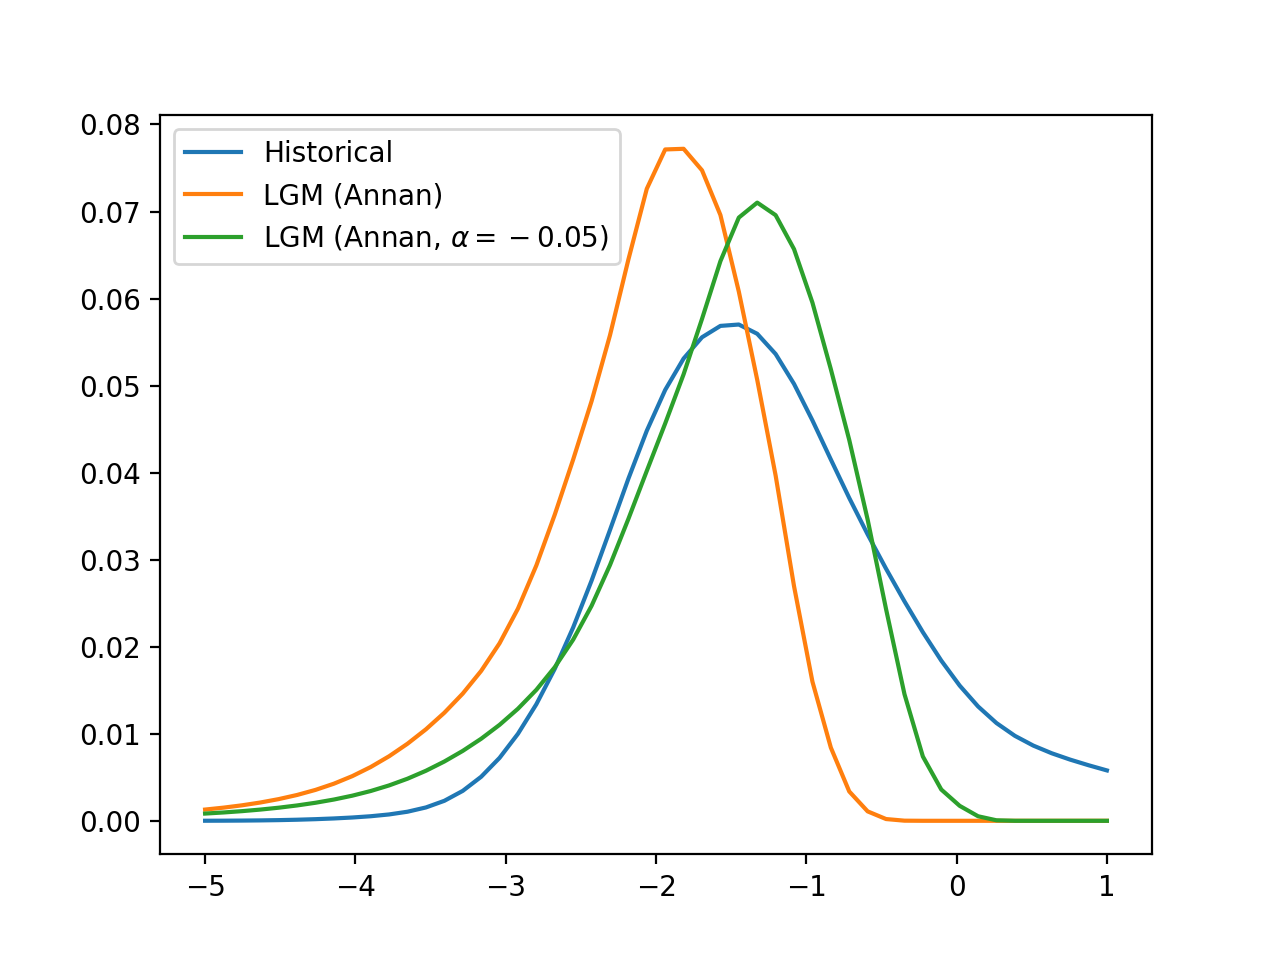

In [143]:
process_kde=stats.gaussian_kde(np.random.normal(-1.33,.44,100000))
fig=plt.figure()
ax=fig.add_subplot(111)
plt.plot(lams,np.array(tst_lams)/np.sum(np.array(tst_lams)),label="Historical")
#plt.plot(lams,process_kde(lams),label="Process")
plt.plot(lams,np.array(LGM_zeroalpha)/np.sum(np.array(LGM_zeroalpha)),label="LGM (Annan)")
plt.plot(lams,np.array(LGM_smallalpha)/np.sum(LGM_smallalpha),label=r"LGM (Annan, $\alpha=-0.05$)")
#joint=np.array(LGM_zeroalpha)*np.array(tst_lams)*np.array(process_kde(lams))
#plt.plot(lams,joint)
plt.legend()
plt.show()


sample from lambda prior

Calculate joint distribution

We know
$$S = -\frac{F_{2x}}{\lambda}$$

We have 
$$P(evidence | \lambda)$$
So we know
$$P(\lambda | evidence) = P(evidence | \lambda ) P(\lambda)$$
We want
$$P(S| evidence)$$

In [76]:
#draw samples from uniform lambda prior
LGM_test=[]
lambda_samples=np.random.uniform(-5,5,nsamp)
for lam in lambda_samples:
    LGM_test+=[likelihood_density_LGM(lam,0)]
LGM_test=np.array(LGM_test)

In [144]:
#Eventually modify this to make the joint PDF non independent: dF_LGM depends on dF_2x which means λ likelihood is conditional on dF_2x


<IPython.core.display.Javascript object>


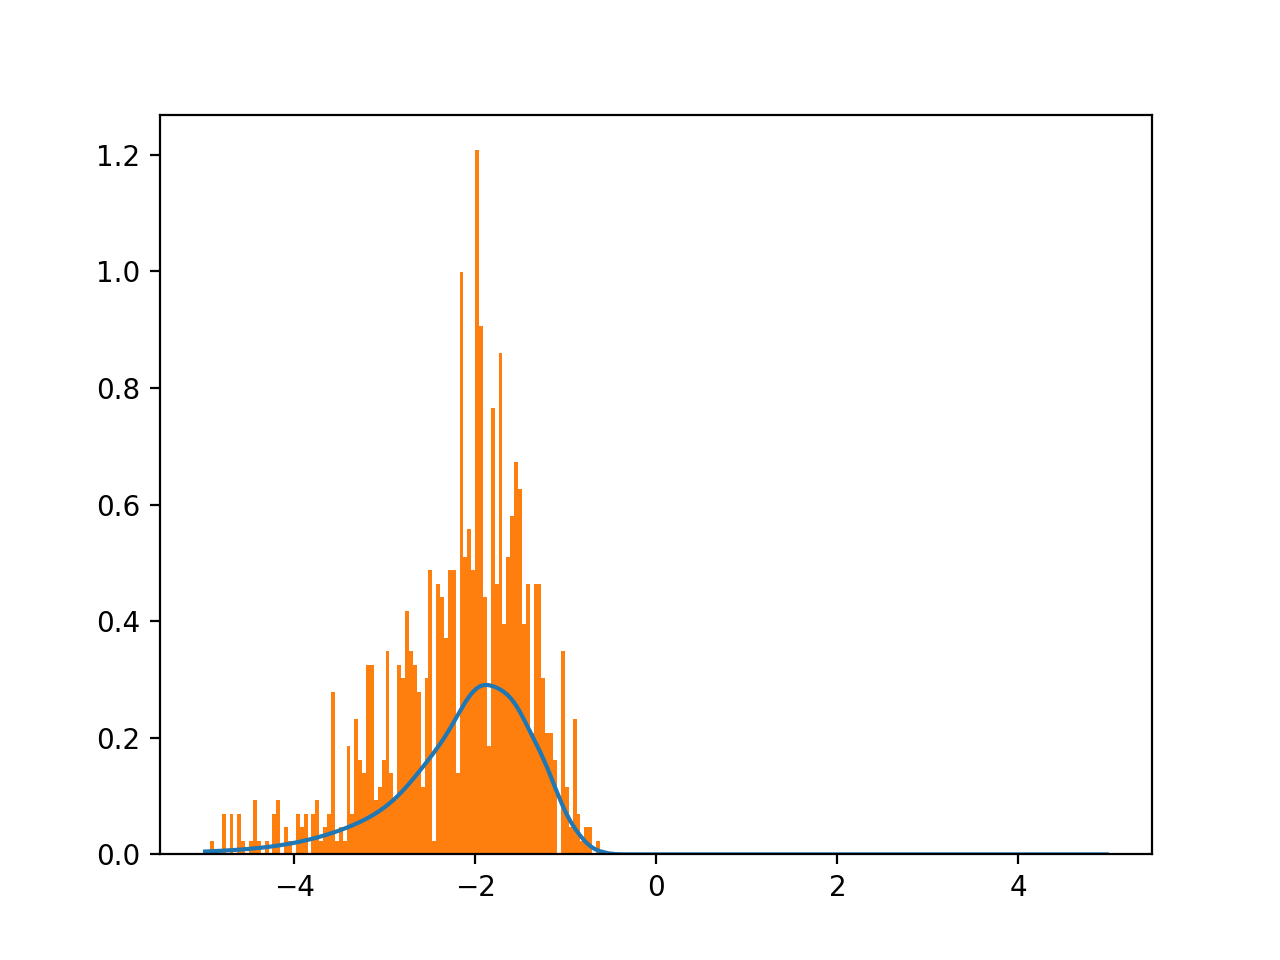

In [146]:
#Resample lambda from the likelihood
from scipy.interpolate import interp1d
fig=plt.figure()
ax=fig.add_subplot(111)
f2 = interp1d(lambda_samples, LGM_test, kind='cubic')
plt.plot(sorted(lambda_samples),f2(sorted(lambda_samples)),"-")
tmp=plt.hist(choices(lambda_samples,LGM_test,k=nsamp),100,density=True)
#kde_lam.resample()

# Calculating S from $\lambda$
S is again deterministic in $F_{2xCO_2}$ and $\lambda$: if I knew those parameters exactly, I'd know S exactly.  Contrast this with a regression model $\lambda = -S F_{2xCO_2}$, in which I'd try to find the posterior distribution of $S$ given (hypothetical) measurements of $\lambda$ and $F_{2xCO2}$.  There isn't any scatter in S except that which comes from the uncertainty in feedbacks and forcing.  

<IPython.core.display.Javascript object>


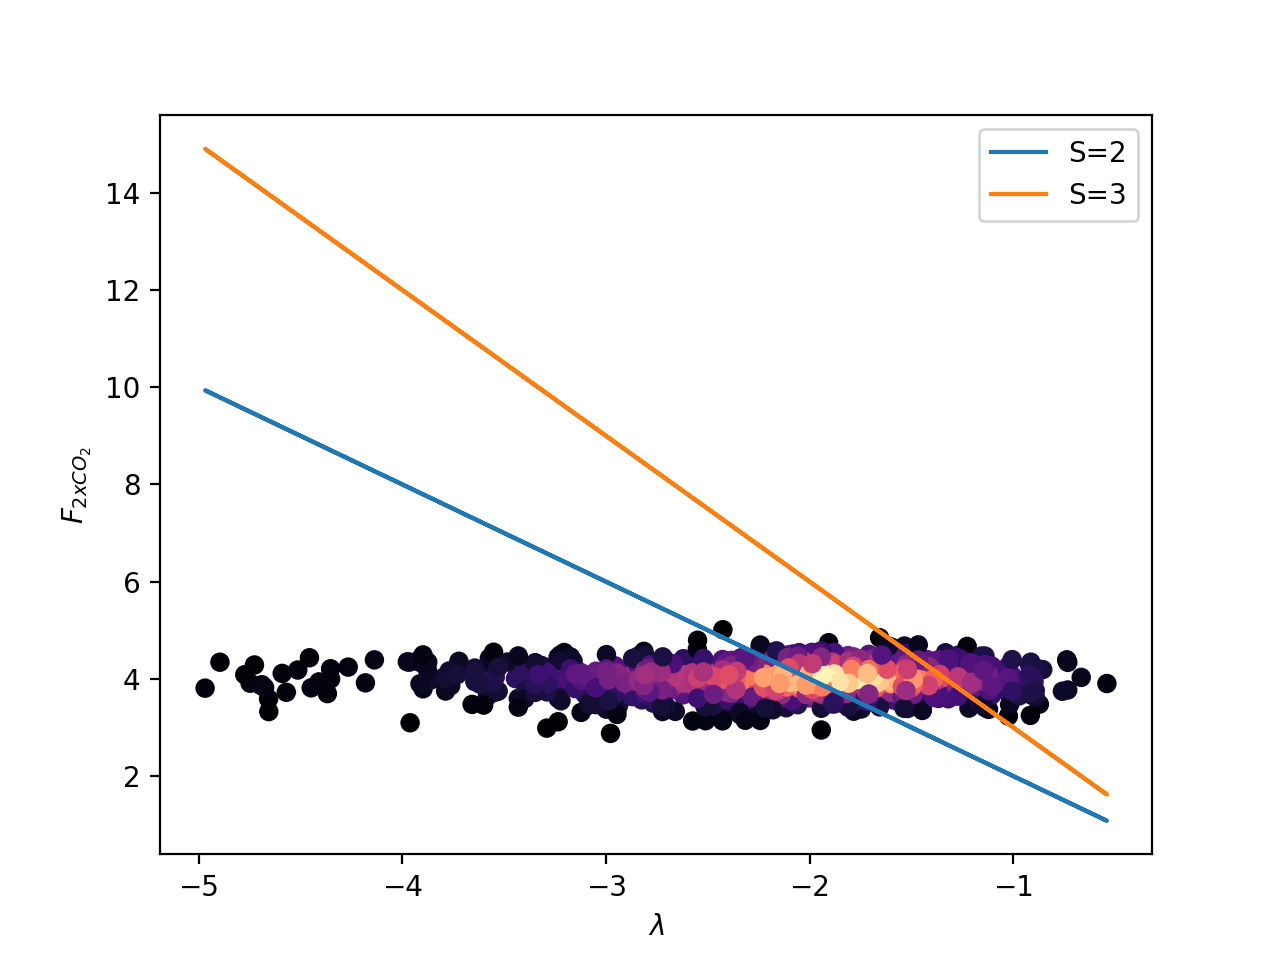

In [152]:
S_values=np.zeros((2,nsamp))
S_values[0]=choices(lambda_samples,LGM_test,k=nsamp)#Sample from the lambda posterior
S_values[1]= F2x_error

fig=plt.figure()
ax=fig.add_subplot(111)
S_kde=stats.gaussian_kde(S_values)

ax.scatter(S_values[0],S_values[1],  c=S_kde(S_values))
plt.ylabel(r"$F_{2xCO_2}$")
plt.xlabel(r"$\lambda$")

S=2.
xtest=S_values[0]
ax.plot(xtest,-S*xtest,label="S=2")
S=3.
xtest=S_values[0]
ax.plot(xtest,-S*xtest,label="S=3")
plt.legend()

So the likelihood of $F_{2xCO_2} $ and $\lambda$ given S is just the line integral over the curve defined by the relationship above.  (Compare this to Eq (17) in Sherwood et al, where something similar is done to marginalize over $\lambda$ and $F_{2x}$. 

In [126]:
#Line integral along S=-F/λ
def likelihood_density_S(S,tmin=-np.inf,tmax=np.inf):

    integrand=lambda t: S_kde((t,-S*t))*np.sqrt(S**2+1)
    return(integrate.quad(integrand,tmin,tmax)[0])

In [132]:
Stest=[]
for ssamp in np.linspace(-1,10,100):
    Stest+=[likelihood_density_S(ssamp)]

<IPython.core.display.Javascript object>


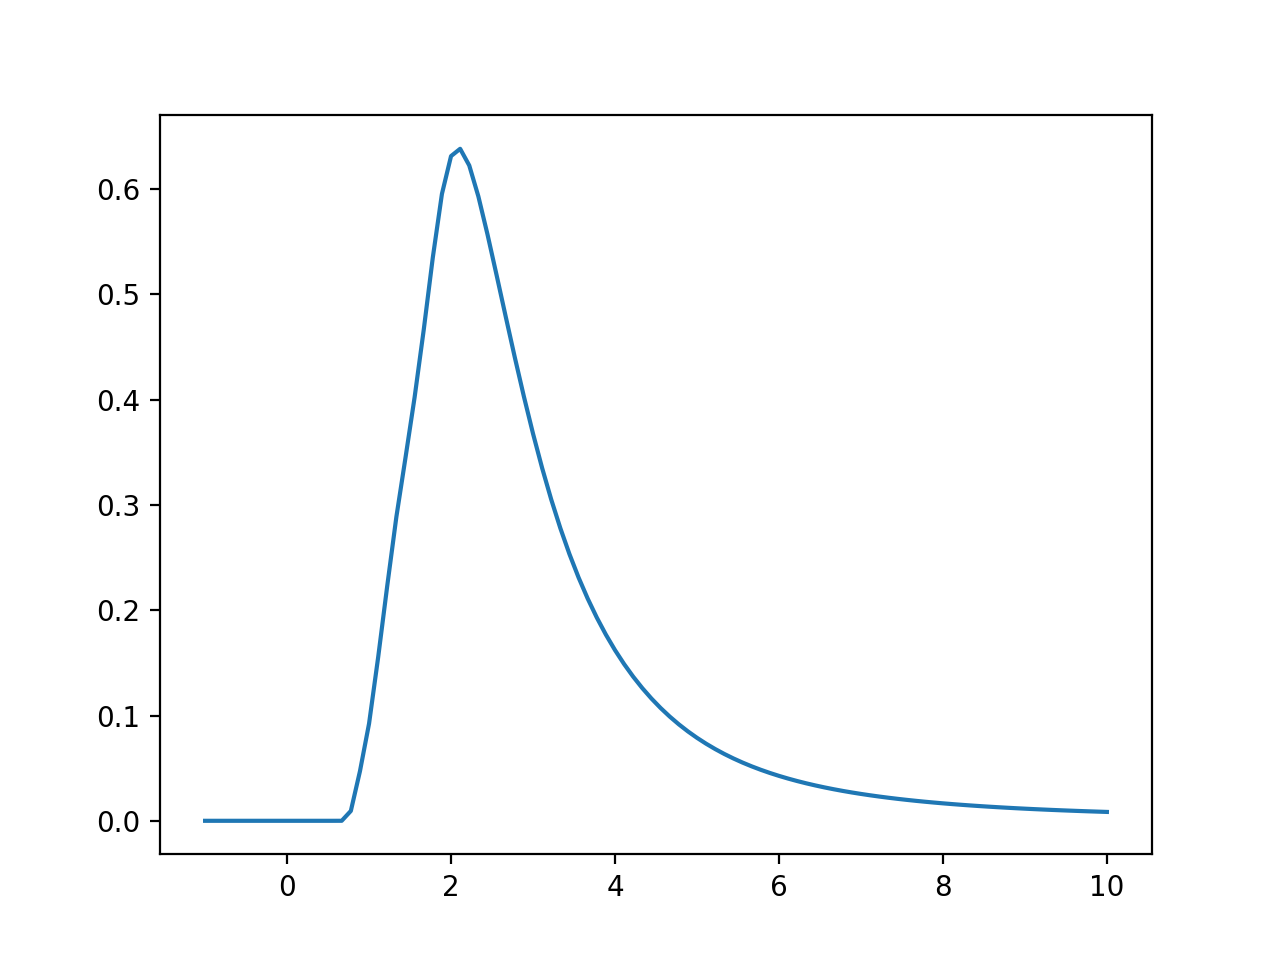

In [133]:
fig=plt.figure()
ax=fig.add_subplot(111)
plt.plot(np.linspace(-1,10,100),Stest)

In [153]:
fourD_values=np.zeros((4,nsamp))
fourD_values[0]=dT_obs
fourD_values[1]=dF_obs
fourD_values[2]=dN_obs
fourD_values[3]=F2x_error


fourD_kde=stats.gaussian_kde(fourD_values)